In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

import gower


2022-06-14 06:37:29.383814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 06:37:29.383843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
df = pd.read_csv("../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_Network_dataset/Train_Test_Network.csv")
df.head()
reduced_df = df[["src_port", "proto", "service", "dst_port", "duration", "label"]]
    #'proto', 'service', 'conn_state', 'dns_query', 'ssl_version',
    # 'ssl_cipher', 'ssl_subject', 'ssl_issuer', 'http_method', 'http_uri',
    # 'http_version', 'http_orig_mime_types', 'http_resp_mime_types',
    # 'weird_name', 'weird_addl']]
df = reduced_df

sampled_df = df.sample(3000)
sampled_labels = sampled_df.pop('label')
sampled_df.pop('type')

gower_mat = gower.gower_matrix(sampled_df)

262105      normal
322843    password
184659         dos
137548      normal
302842      normal
            ...   
341180      normal
170166         dos
446373    backdoor
121689      normal
241477      normal
Name: type, Length: 3000, dtype: object

In [83]:

transformer = make_column_transformer(
    (OneHotEncoder(), ['proto', 'service']),
    # 'ssl_cipher', 'ssl_subject', 'ssl_issuer', 'http_method', 'http_uri',
    # 'http_version', 'http_orig_mime_types', 'http_resp_mime_types',
    # 'weird_name', 'weird_addl']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)

In [84]:
df = transformed_df
transformed_df.shape

(461043, 17)

In [85]:
# Percentage malware
perc = len(df.loc[df['remainder__label']==1])/len(df)
print(perc)

0.34930147513355586


In [86]:
# Balance dataset
num_anom = len(df.loc[df['remainder__label']==1.])
df_anom = df.loc[df['remainder__label']==1.]
df_normal = df.loc[df['remainder__label']==0.]
df_normal = df_normal.sample(num_anom, replace=False)
df_concated = pd.concat([df_normal, df_anom])
data = df_concated

In [87]:
labels = data.pop('remainder__label')

In [88]:
data_scaled = data.copy()
min_max_scaler = MinMaxScaler()
#data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]] = min_max_scaler.fit_transform(data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]])
data_scaled[data_scaled.columns] = min_max_scaler.fit_transform(data_scaled[data_scaled.columns])

In [89]:
print(data_scaled.shape)

(322086, 16)


In [90]:
train_data, test_data, train_labels, test_labels = train_test_split(data_scaled, labels, test_size=0.33, random_state=21)

In [91]:
# Separe normal and anomaly classes
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [92]:
print(normal_train_data.iloc[0])

onehotencoder__proto_icmp            0.000000
onehotencoder__proto_tcp             1.000000
onehotencoder__proto_udp             0.000000
onehotencoder__service_-             1.000000
onehotencoder__service_dce_rpc       0.000000
onehotencoder__service_dhcp          0.000000
onehotencoder__service_dns           0.000000
onehotencoder__service_ftp           0.000000
onehotencoder__service_gssapi        0.000000
onehotencoder__service_http          0.000000
onehotencoder__service_smb           0.000000
onehotencoder__service_smb;gssapi    0.000000
onehotencoder__service_ssl           0.000000
remainder__src_port                  0.761189
remainder__dst_port                  0.001221
remainder__duration                  0.000000
Name: 419902, dtype: float64


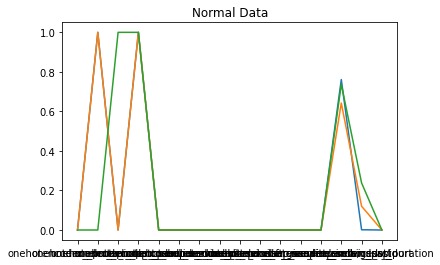

In [93]:
plt.plot(normal_train_data.iloc[0])
plt.plot(normal_train_data.iloc[1])
plt.plot(normal_train_data.iloc[2])
plt.title("Normal Data")
plt.show()

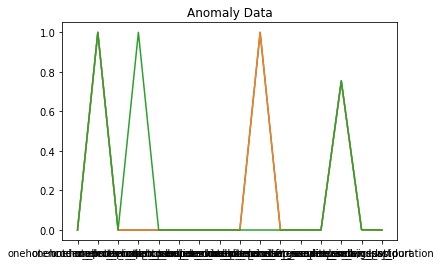

In [94]:
plt.plot(anomalous_train_data.iloc[0])
plt.plot(anomalous_train_data.iloc[1])
plt.plot(anomalous_train_data.iloc[2])
plt.title("Anomaly Data")
plt.show()

In [95]:
train_data = np.array(train_data)
normal_train_data = np.array(normal_train_data)
normal_test_data = np.array(normal_test_data)
anomalous_train_data = np.array(anomalous_train_data)
anomalous_test_data = np.array(anomalous_test_data)

In [96]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(16, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [97]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data, train_data),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
901/901 [==============================] - 3s 3ms/step - loss: 0.0980 - val_loss: 0.0537
Epoch 2/50
901/901 [==============================] - 2s 3ms/step - loss: 0.0616 - val_loss: 0.0507
Epoch 3/50
901/901 [==============================] - 2s 3ms/step - loss: 0.0535 - val_loss: 0.0373
Epoch 4/50
901/901 [==============================] - 2s 3ms/step - loss: 0.0510 - val_loss: 0.0377
Epoch 5/50
901/901 [==============================] - 2s 3ms/step - loss: 0.0507 - val_loss: 0.0349
Epoch 6/50
901/901 [==============================] - 2s 3ms/step - loss: 0.0506 - val_loss: 0.0364
Epoch 7/50
901/901 [==============================] - 2s 3ms/step - loss: 0.0505 - val_loss: 0.0360


In [98]:
encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()

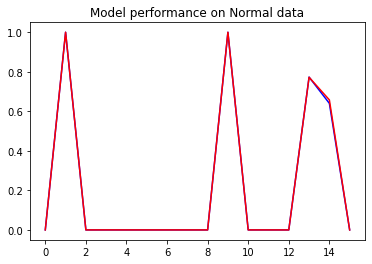

In [99]:
plt.plot(normal_test_data[1], 'b')
plt.plot(decoder_out[1], 'r')
plt.title("Model performance on Normal data")
plt.show()

In [100]:
encoder_out_a = model.encoder(anomalous_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()

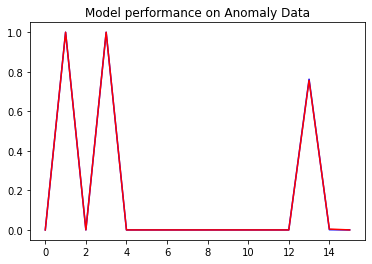

In [101]:
plt.plot(anomalous_test_data[2], 'b')
plt.plot(decoder_out_a[2], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

In [102]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
#plt.hist(train_loss, bins=50)

In [103]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomalous_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomalous_test_data)

In [104]:
# plt.hist(train_loss_a, bins=50)
# plt.title("loss on anomaly test data")
# plt.show()

In [105]:
# plt.hist(train_loss, bins=50, label='normal')
# plt.hist(train_loss_a, bins=50, label='anomaly')
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
# plt.legend(loc='upper right')
# plt.title("Normal and Anomaly Loss")
# plt.show()

In [106]:
preds = tf.math.less(train_loss, threshold)
num = tf.math.count_nonzero(preds)
#Percentage of correclty classified normal
print(num/len(normal_test_data))

tf.Tensor(1.0, shape=(), dtype=float64)


In [107]:
preds_a = tf.math.greater(train_loss_a, threshold)
num = tf.math.count_nonzero(preds_a)
#Percentage of correclty classified anomaly
print(num/len(anomalous_test_data))

tf.Tensor(0.0, shape=(), dtype=float64)


# Other method

Separate normal and abnormal classes

Plot a normal and an abnormal modbus

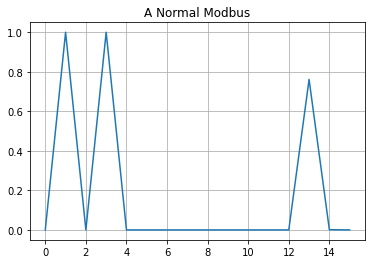

In [108]:
plt.grid()
plt.plot(np.arange(16), normal_train_data[0])
plt.title("A Normal Modbus")
plt.show()


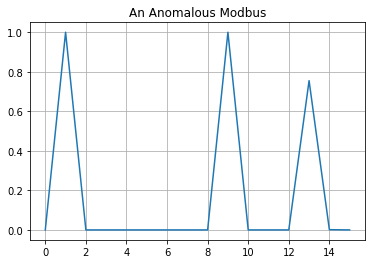

In [109]:
plt.grid()
plt.plot(np.arange(16), anomalous_train_data[0])
plt.title("An Anomalous Modbus")
plt.show()

### Build the model - OVERCOMPLETE AE
Dont use mean squared error in classification; cross entropy yes. However, training the AE with just normal data is not a classification task

### Training the AE with normal data

In [110]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(16, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()


In [111]:
autoencoder.compile(optimizer='adam', loss='mae')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")


The training is just performed with normal instance. However, test is done with all the instances.

In [112]:
# USAGE OF TEST DATA TO VAL NOT FAIR
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50,
          batch_size=32,
          validation_data=(test_data, test_data),
          shuffle=True,
          callbacks = [early_stopping])


Epoch 1/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.0495 - val_loss: 0.0306
Epoch 2/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.0104 - val_loss: 0.0147
Epoch 3/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.0082 - val_loss: 0.0139
Epoch 4/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.0079 - val_loss: 0.0133
Epoch 5/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.0077 - val_loss: 0.0133
Epoch 6/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.0075 - val_loss: 0.0125
Epoch 7/50
3378/3378 [==============================] - 6s 2ms/step - loss: 0.0074 - val_loss: 0.0127
Epoch 8/50
3378/3378 [==============================] - 6s 2ms/step - loss: 0.0074 - val_loss: 0.0125
Epoch 9/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.0073 - val_loss: 0.0124
Epoch 10/50
3378/3378 [==============================] - 7s 2ms/step - loss: 0.007

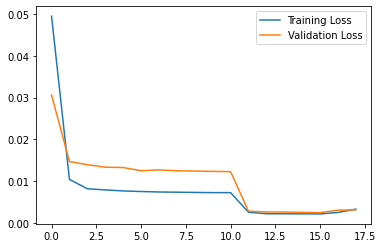

In [113]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


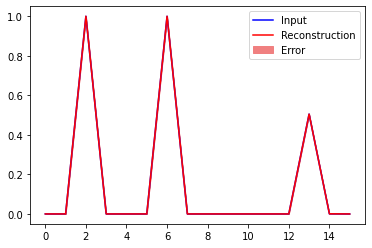

In [115]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(16), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


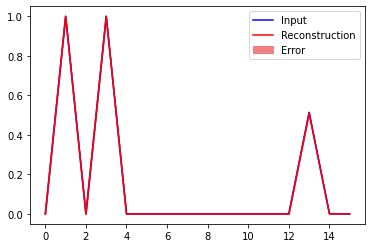

In [116]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(16), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Detect anomalies by calculating the reconstruction lose of a fixed threshold.

Calculate the mean error for normal training examples to classify future anomalies if the error is greater than a StandDeviat of the train set.

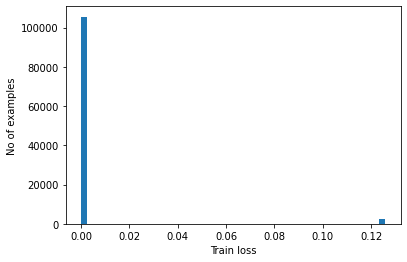

In [117]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mean_squared_error(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


Select a value a std greater from the mean

In [118]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.021938657022084133


Error of abnormal MODBUS in test set

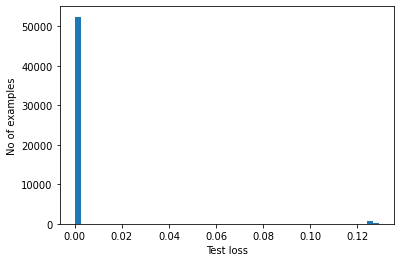

In [119]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mean_squared_error(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


Classify instance as abnormal if the reconstruction error is greater than the threshold

In [120]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mean_squared_error(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions))) #sensitivity
  print("F1 = {}".format(f1_score(labels, predictions)))
  print("ROC_AUC = {}".format(roc_auc_score(labels, predictions)))



In [121]:
# Results dont make sense give more weight to anomaly class in the learning process
preds = predict(autoencoder, np.array(test_data), threshold)
print_stats(preds, test_labels)

Accuracy = 0.5061201065020839
Precision = 0.5039252946370302
Recall = 0.9849002100840336
F1 = 0.6667216903268405
ROC_AUC = 0.5046063237784496
